The purpose of this exercise will be to reframe the median house value problem we have been exploring as a binary classification problem and learn the mechanics of developing a logistic regression model in TF. We will then compare the effectiveness of logistic regression and classical linear regression for this problem. 

Lets start by framing our continuous linear regression problem as a classification problem. We wish to predict if a particular city block is a high cost city block. We set our classification threshold as 75th percentile for median house value (approx. $265,000). If the value is above this value, we label it as a 1 and 0 otherwise.

Just to be clear, this classification threshold was chosen quite arbitrarily (seemed like a good amount). 

In [1]:
#to bring print function from later versions of python into this one
from __future__ import print_function
import math
from IPython import display

#for data visualization & interaction
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

#support for higher dimensional objects in data manipulation
import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

#so we are not flooded with output anytime we print out the results
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

#DONT FORGET TO RANDOMIZE THE DATA!
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))



In [2]:
"""Pre-processes input features from California Housing Dataset
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A dataframe containing the features to be used for the model
        including synthetic features

"""
def preprocess_features(california_housing_dataframe):
    
    selected_features = california_housing_dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]
    
    processed_features = selected_features.copy()
    
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/
        california_housing_dataframe["population"])
    
    return processed_features


""" Prepare target features or labels
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A pandas dataframe containing target features

"""
def preprocess_targets(california_housing_dataframe):

    output_targets = pd.DataFrame()
    #essentially, fill column with boolean then casting to a float 1,0 (automatic cast for booleans)
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    
    return output_targets




Once again, we split the training and validation examples in the following code block:

In [3]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary")
display.display(training_examples.describe())

print("Validation examples summary")
display.display(validation_examples.describe())

print("Training targets summary")
display.display(training_targets.describe())

print("Validation targets summary")
display.display(validation_targets.describe())

Training examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2656.0,541.4,1431.6,502.9,3.9,2.0
std,2.1,2.0,12.6,2208.7,427.2,1154.6,390.3,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.0,296.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,433.0,1165.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3162.2,651.2,1717.0,607.0,4.8,2.3
max,42.0,-114.6,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.9,2614.0,534.7,1424.8,497.1,3.9,2.0
std,2.1,2.0,12.6,2109.3,407.5,1131.7,370.2,1.9,1.0
min,32.5,-124.3,2.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1467.0,299.0,786.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,435.0,1170.5,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3114.2,643.0,1729.0,601.0,4.8,2.3
max,41.8,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,41.3


Training targets summary


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Everything looks good. Now lets take a look at applying an ordinary linear regression model to our classification problem. It will use the labels {0,1} in the feature data and try to predict a continuous value as close as possible to either 0,1. Then we can apply a threshold of 0.5 to determine the label as 0,1.

The following cells will create and train our linear regressor model (as we have done in previous exercises)

In [4]:
"""Construct TF feature columns

    Args:
        input_features: Names of input features to use
    Returns: 
        set of feature columns

"""
def construct_feature_columns(input_features):
    
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])
    

In [5]:
"""Trains a linear regression model.
    Args: 
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Int size of batches to be passed to the model
        shuffle: Boolean of whether to shuffle the data
        epochs: Int Number of epochs for which data should be repeated.
            default value = None
    Returns:
        Tuple of (features, labels) for the next data batch
    
""" 
def my_input_func(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    
    #converts pandas data into a dict of numpy arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    #constructs dataset and configures batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #shuffle data, if specified by user
    if shuffle:
        ds = ds.shuffle(10000)
    
    #return next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [23]:
"""This function trains a linear regression model of multiple features

    Args:
        learning_rate: A 'float', learning rate
        steps: A non-zero 'int', total training steps taken (each step is forward
            and backward pass using single batch)
        batch_size: A non-zero 'int', the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A LinearRegressor object trained on training data
        Plots RMSE value at each training period step 

"""
def train_linear_regressor_model(learning_rate, steps, batch_size, training_examples, 
                                training_targets, validation_examples, validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    #creating linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer)
    
    #create input functions
    training_input_func = lambda:my_input_func(training_examples, 
                                               training_targets["median_house_value_is_high"],
                                               batch_size = batch_size)
    
    predict_training_input_func = lambda:my_input_func(training_examples,
                                                       training_targets["median_house_value_is_high"],
                                                       num_epochs = 1,
                                                       shuffle = False)
    
    predict_validation_input_func = lambda:my_input_func(validation_examples,
                                                         validation_targets["median_house_value_is_high"],
                                                         num_epochs = 1,
                                                         shuffle = False)
    
    #Train the model in a for loop to periodically asses loss metrics
    print("Training model...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        
        #train model starting from last state
        linear_regressor.train(
            input_fn = training_input_func,
            steps = steps_per_period
        )
        
        #compute predictions
        training_predictions = linear_regressor.predict(input_fn = predict_training_input_func)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_func)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        #compute training and validation losses
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #occasionally print current loss
        print(" period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        #add prior loss metrics to our lists
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model Training complete")
    
    #output graph of loss metrics
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root mean squared error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label = "training")
    plt.plot(validation_rmse, label = "validation")
    plt.legend()
    
    return linear_regressor

Lets run a basic model below and see what we get as output

Training model...
RMSE (on training data): 
 period 00 : 0.50
 period 01 : 0.50
 period 02 : 1.52
 period 03 : 1.49
 period 04 : 1.51
 period 05 : 1.51
 period 06 : 1.55
 period 07 : 1.56
 period 08 : 1.56
 period 09 : 1.56
Model Training complete


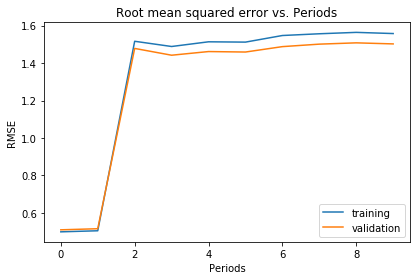

In [24]:
linear_regressor = train_linear_regressor_model(
    learning_rate = 0.0001,
    steps = 100,
    batch_size = 20,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets)

So, if RMSE comes out in the same units as our target variable, and our target variable is a probabilistic binary classifier, what does the training error above indicate? (Hint: Its sh!t) 

Also, take note that re-running the model leads to different convergence rates and vastly different RMSE (if you can even call it convergence at this point) which is a pretty good indicator that something isnt working as it should (i.e. model misspecification). 

Lets take a closer look at the validation predictions:

(array([3.823e+03, 9.640e+02, 1.430e+02, 3.900e+01, 1.400e+01, 1.000e+01,
        3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([ 0.04502177,  1.60666692,  3.16831207,  4.72995722,  6.29160237,
         7.85324752,  9.41489267, 10.97653782, 12.53818297, 14.09982812,
        15.66147327]),
 <a list of 10 Patch objects>)

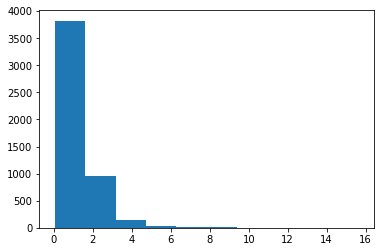

In [30]:
predict_validation_input_func = lambda: my_input_func(validation_examples,
                                                      validation_targets["median_house_value_is_high"],
                                                      num_epochs = 1,
                                                      shuffle = False)

validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_func)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

plt.hist(validation_predictions)


So, we do end up making a fair few probabilistic predictions for our target $\in(0,1)$ but since there are a fair number of observations above this range, using a linear regressor model ends up being a pretty terrible idea.

A full discussion wont be discussed here but there are alot of awesome resources online that help explain why, just click [here](http://thestatsgeek.com/2015/01/17/why-shouldnt-i-use-linear-regression-if-my-outcome-is-binary/)

### Lets move on...

Alright, now lets actually correctly specify our classification model. Luckily, all we have to do is use LinearClassifier instead of LinearRegressor in our train model function. 

Another key distinction is that when running train() and predict() on a LinearClassifier model, we can access the probabilities predicted using the "probabilities" key in the returned dict of the model. We then pass this value to Sklearns log_loss function to expedite our model evaluation. 

In [38]:
"""This function trains a linear classification model of multiple features

    Args:
        learning_rate: A 'float', learning rate
        steps: A non-zero 'int', total training steps taken (each step is forward
            and backward pass using single batch)
        batch_size: A non-zero 'int', the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A LinearClassifier object trained on training data
        Plots log loss value at each training period step 

"""
def train_linear_classifier_model(learning_rate, steps, batch_size, training_examples,
                                  training_targets,validation_examples,validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
  
    # Create a linear classifier object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
  
    # Create input functions.
    training_input_func = lambda: my_input_func(training_examples, 
                                            training_targets["median_house_value_is_high"], 
                                            batch_size=batch_size)
    
    predict_training_input_func = lambda: my_input_func(training_examples, 
                                                    training_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    predict_validation_input_func = lambda: my_input_func(validation_examples, 
                                                      validation_targets["median_house_value_is_high"], 
                                                      num_epochs=1, 
                                                      shuffle=False)
  
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    
    training_log_losses = []
    validation_log_losses = []

    for period in range (0, periods):
        
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_func,
            steps=steps_per_period
        )
    
        # Take a break and compute predictions.    
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_func)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_func)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
        #sklearn imported as metrics...
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    
        #print current loss every so often
        print("  period %02d : %0.2f" % (period, training_log_loss))
    
        #add loss metrics from current period to our lists
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
        
    print("Model training complete!")
    
    #output graph of loss metrics
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label = "training")
    plt.plot(validation_log_losses, label = "validation")
    plt.legend()
    
    return linear_classifier
    

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.58
  period 02 : 0.57
  period 03 : 0.55
  period 04 : 0.54
  period 05 : 0.54
  period 06 : 0.54
  period 07 : 0.53
  period 08 : 0.53
  period 09 : 0.53
Model training complete!


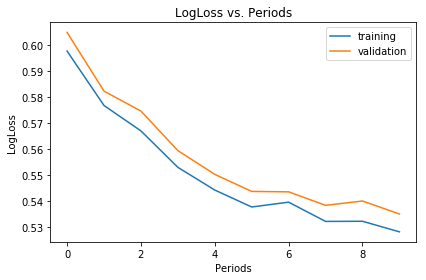

In [40]:
linear_classifier = train_linear_classifier_model(
    learning_rate = 0.000005,
    steps = 500,
    batch_size = 20,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)


So thats definitely alot better convergence and predictability wise. Lets take a look at a few metrics that will help us evaluate our model. These things are model accuracy, the Receiver Operating Characteristic (ROC) curve and and the area under ROC (AUC). 

### Evaluation

In [54]:
evaluation_metrics = linear_classifier.evaluate(input_fn = predict_validation_input_func)

print("AUC on validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on validation set: 0.73
Accuracy on validation set: 0.75


1. Accuracy essentially measures the ratio of correctly predicted observations to total observations. So we definitely do better than random guessing. But lets take a closer look at the balance of our validation dataset

In [69]:
validation_targets.groupby('median_house_value_is_high').size()

median_house_value_is_high
0.0    3714
1.0    1286
dtype: int64

So, we have about 74% of our validation data as zeros and the remaining as 1. If we assigned every value in our validation set a 0, we would have gotten an accuracy pretty close to the accuracy our model produced. Clearly accuracy is necessary but not a sufficient metric to measure model specification.

The ROC of our model essentially shows us the performance of the model at all classification thresholds. It does this by plotting the true positive rate against the false positive rate. 

The AUC measures the area under the curve of the ROC. An intuitive way to think about it is the probability the model ranks/predicts a random positive result (i.e. a 1) greater than a random negative result (a 0). An AUC of 0.5 indicates a random predictor so its definitely a good sign our AUC is much higher than this. 

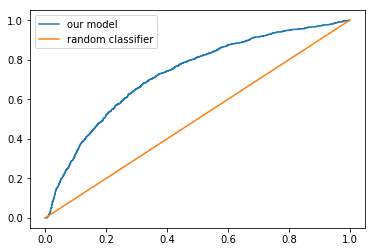

In [71]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_func)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

The ROC curve plotted above essentially tells the tradeoff between sensitivity and specificity. The closer the curve follows the left-handed border and then the top border indicates a higher accuracy of our model. 


### ROC, AUC and Binary Classification

(Provide more in depth intuitive understanding of parameters above from notebook)

Can we do any better? I leave it up to the reader to explore tuning hyperparameters to get a higher AUC... (Hint: remember what we are doing by training and how complexity changes with the number of steps and batch size!)